---
highlight-style:
  light: arrow.theme
  dark: arrow-dark.theme
format:
  html:
    code-line-numbers: true
    code-overflow: wrap
---

# Traveling Salesman Problem {#sec-ip-tsp}

The traveling salesman problem (TSP) is a classic optimization problem in computer science and operations research. The problem can be stated as follows: given a set of cities and the distances between them, what is the shortest possible route that visits each city exactly once and returns to the starting city?

The TSP has many real-world applications, including logistics and transportation planning, circuit board drilling, and DNA sequencing.
However, it is a well-known NP-hard problem, meaning that finding an optimal solution is computationally difficult for large instances of the problem. 
As a result, many heuristic and approximation algorithms have been developed to find suboptimal solutions that are still very good in practice.
In this chapter, we present several mathematical formulations of the TSP existing in the literature and implement them using OR-Tools.

## TSP Instances

Before discussing the mathematical models of the TSP, we first provide an introduction to the instances that will be utilized to test various formulations and illustrate the resulting TSP solutions. 
The TSP is a widely recognized optimization problem that has been studied for several decades. 
Due to its significance, many benchmarking problem instances of varying sizes are available in literature. 
In this chapter, we do not aim to solve the most challenging TSP instances, but instead, our objective is to demonstrate how to apply different formulations of the TSP using OR-Tools.

To achieve this objective, we will focus on presenting some of the small-sized instances that can be solved effectively using OR-Tools. 
These instances are well-documented, which makes them easy to understand and implement in practice. Additionally, they help illustrate the optimization techniques used to solve the TSP, such as branch-and-bound and cutting plane methods. 
Moreover, small-sized instances allow for quicker computation, making it easier to observe the behavior of different algorithms and identify which formulations are most efficient.

By presenting a range of examples, we aim to provide a clear understanding of how to implement different TSP formulations using OR-Tools, which can be applied to real-world problems in various domains, such as transportation planning and logistics, network design, and circuit board drilling. 
Additionally, we aim to demonstrate the advantages and limitations of different TSP formulations and algorithms, highlighting which techniques perform well under specific circumstances. 
By doing so, readers can gain insight into how to apply TSP optimization techniques to their own problems effectively.

### TSPLIB

The TSP instances used in this section are sourced from [TSPLIB95](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/), a library of TSP benchmark instances. 
To make it easier to work with these instances, we utilize the `tsplib95` Python library, which can be installed using the `pip install tsplib95` command.

In the code snippet below, we demonstrate how to use the `tsplib95` package to load the *ulysses22.tsp* problem from a data file downloaded from TSPLIB95. 
The loaded data can be used to formulate and solve TSP instances using OR-Tools or other optimization tools. The full instance data is provided at the end for reference.
 By leveraging the `tsplib95` package, we can quickly and easily access TSP instances for experimentation and analysis, and focus our efforts on the formulation and optimization aspects of the problem.

In [17]:
import tsplib95

# load problem
problem = tsplib95.load('./data/tsp/ulysses22.tsp')

# show instance
problem.as_name_dict()

{'name': 'ulysses22.tsp',
 'comment': 'Odyssey of Ulysses (Groetschel/Padberg)',
 'type': 'TSP',
 'dimension': 22,
 'edge_weight_type': 'GEO',
 'display_data_type': 'COORD_DISPLAY',
 'node_coords': {1: [38.24, 20.42],
  2: [39.57, 26.15],
  3: [40.56, 25.32],
  4: [36.26, 23.12],
  5: [33.48, 10.54],
  6: [37.56, 12.19],
  7: [38.42, 13.11],
  8: [37.52, 20.44],
  9: [41.23, 9.1],
  10: [41.17, 13.05],
  11: [36.08, -5.21],
  12: [38.47, 15.13],
  13: [38.15, 15.35],
  14: [37.51, 15.17],
  15: [35.49, 14.32],
  16: [39.36, 19.56],
  17: [38.09, 24.36],
  18: [36.09, 23.0],
  19: [40.44, 13.57],
  20: [40.33, 14.15],
  21: [40.37, 14.23],
  22: [37.57, 22.56]}}

The list of nodes can be retrieved using the `get_nodes()` function, as shown below.

In [18]:
list(problem.get_nodes())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

To get the distance between any pair of nodes, we use the `get_weight()` function.

In [19]:
print(f'distance between node 1 and 2 = {problem.get_weight(1, 2)}')

distance between node 1 and 2 = 509


### Visualize TSP Solution



In this section, our goal is to gain a better understanding of the TSP problem by visualizing the optimal solution found for instances provided by TSPLIB95. 
To achieve this, we define a class called `TspVisualizer` in our code that is responsible for displaying the route that connects all nodes in a TSP solution. 
The `TspVisualizer` class contains a single function, called `show(locations, edges)`, which accepts two input parameters: *locations* and *edges*.

The *locations* parameter is a dictionary that contains the mapping between location ID and its corresponding coordinates. 
The *edges* parameter is a list of edges that form the TSP tour. 
By calling the show function with the appropriate input parameters, we can visualize the TSP tour and gain an intuitive understanding of what the TSP problem is trying to accomplish. 
This visualization can be a helpful tool in understanding how the different TSP formulations and algorithms work, and can aid in identifying potential improvements to the solution. 
The use of the `TspVisualizer` class allows for easy visualization of the TSP solution and makes it possible to explore and analyze TSP instances in a more meaningful way.

In [63]:
#| code-line-numbers: true

import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class TspVisualizer:
    """visualize a TSP tour
    """
    
    @staticmethod
    def show(locations, edges):
        """draw TSP tour
        adapted from https://stackoverflow.com/a/50682819
        
        examples:
        locations = {
            0: (5, 5),
            1: (4, 9),
            2: (6, 4),
        }

        edges = [
            (0, 1),
            (1, 2),
            (2, 0),
        ]

        Args:
            locations (dict): location id -> (lat, lon)
            edges (list): list of edges
        """
        G = nx.DiGraph()
        G.add_edges_from(edges)
        plt.figure(figsize=(15,10))
        
        colors = mpl.colormaps["Set1"].colors
        color_idx = 1
        color = np.array([colors[color_idx]])
        
        nx.draw_networkx_nodes(G, 
                                locations, 
                                nodelist=[x[0] 
                                        for x in edges], 
                                node_color=color)
        nx.draw_networkx_edges(G,
                                locations, 
                                edgelist=edges,
                                width=4, 
                                edge_color=color, 
                                style='dashed')
        
        # labels
        nx.draw_networkx_labels(G, locations, 
                                font_color='w', 
                                font_size=12, 
                                font_family='sans-serif')

        #print out the graph
        plt.axis('off')
        plt.show()

Now let's load the optimal solution for the aforementioned instance and show its content below.

In [64]:
solution = tsplib95.load('./data/tsp/ulysses22.opt.tour')
solution.as_name_dict()

{'name': 'ulysses22.opt.tour',
 'comment': 'Optimal solution of ulysses22 (7013)',
 'type': 'TOUR',
 'dimension': 22,
 'tours': [[1,
   14,
   13,
   12,
   7,
   6,
   15,
   5,
   11,
   9,
   10,
   19,
   20,
   21,
   16,
   3,
   2,
   17,
   22,
   4,
   18,
   8]]}

The code snippet below plots the optimal tour, which is shown in @fig-tsp-ulysses22-sol.

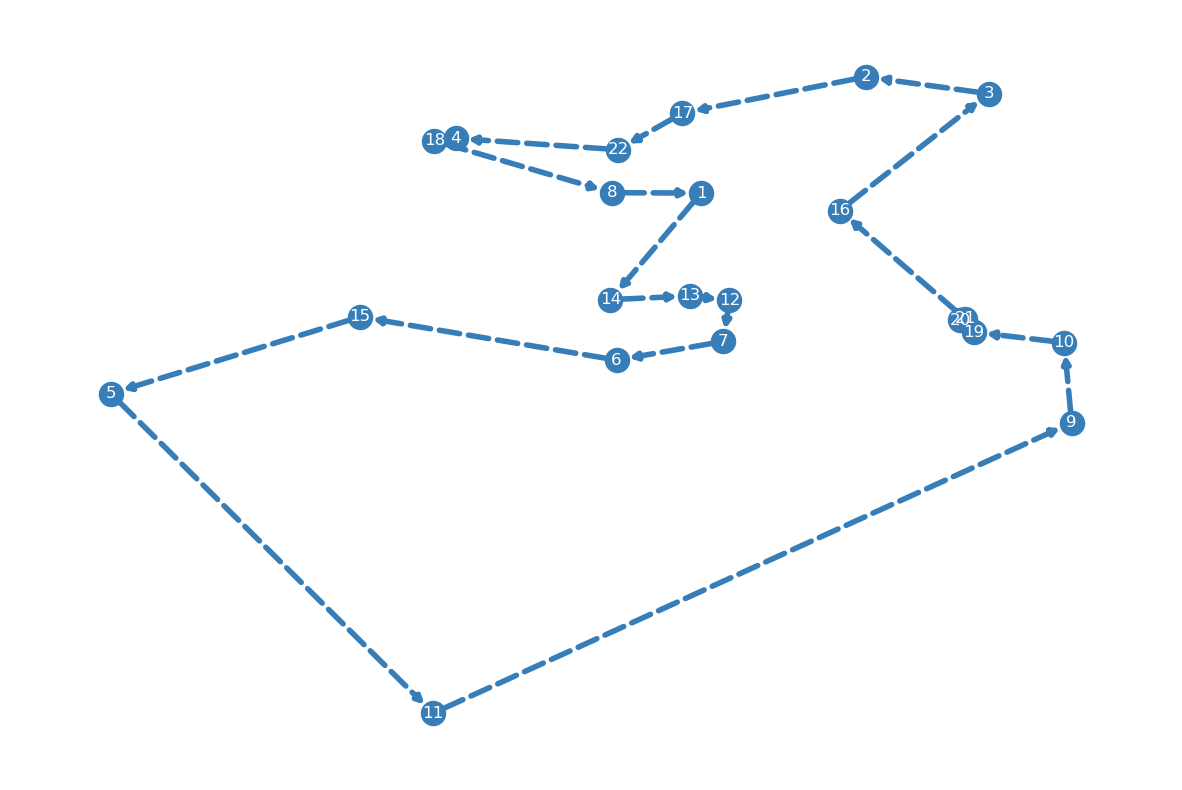

In [69]:
#| echo: true
#| code-line-numbers: true
#| label: fig-tsp-ulysses22-sol
#| fig-cap: Optimal tour of the *ulysses22* instance

locations = problem.node_coords
tour = solution.tours[0]
edges = []
for i in range(len(tour) - 1):
    edges.append((tour[i], tour[i + 1]))
edges.append((tour[-1], tour[0]))
edges = []
for i in range(len(tour) - 1):
    edges.append((tour[i], tour[i + 1]))
edges.append((tour[-1], tour[0]))
TspVisualizer.show(locations, edges)

Let's put this visualization procedure into a dedicated function, as is given below.

In [76]:
import tsplib95

def visualize_tsp(instance_name: str):
    # load problem
    problem = tsplib95.load(f'./data/tsp/{instance_name}.tsp')
    solution = tsplib95.load(f'./data/tsp/{instance_name}.opt.tour')

    locations = problem.node_coords
    tour = solution.tours[0]
    edges = []
    for i in range(len(tour) - 1):
        edges.append((tour[i], tour[i + 1]))
    edges.append((tour[-1], tour[0]))
    edges = []
    for i in range(len(tour) - 1):
        edges.append((tour[i], tour[i + 1]))
    edges.append((tour[-1], tour[0]))
    TspVisualizer.show(locations, edges)

@fig-tsp-berlin52-sol and @fig-tsp-pr76-sol show the optimal tours for the *berlin52* and *pr76* instances, respectively.

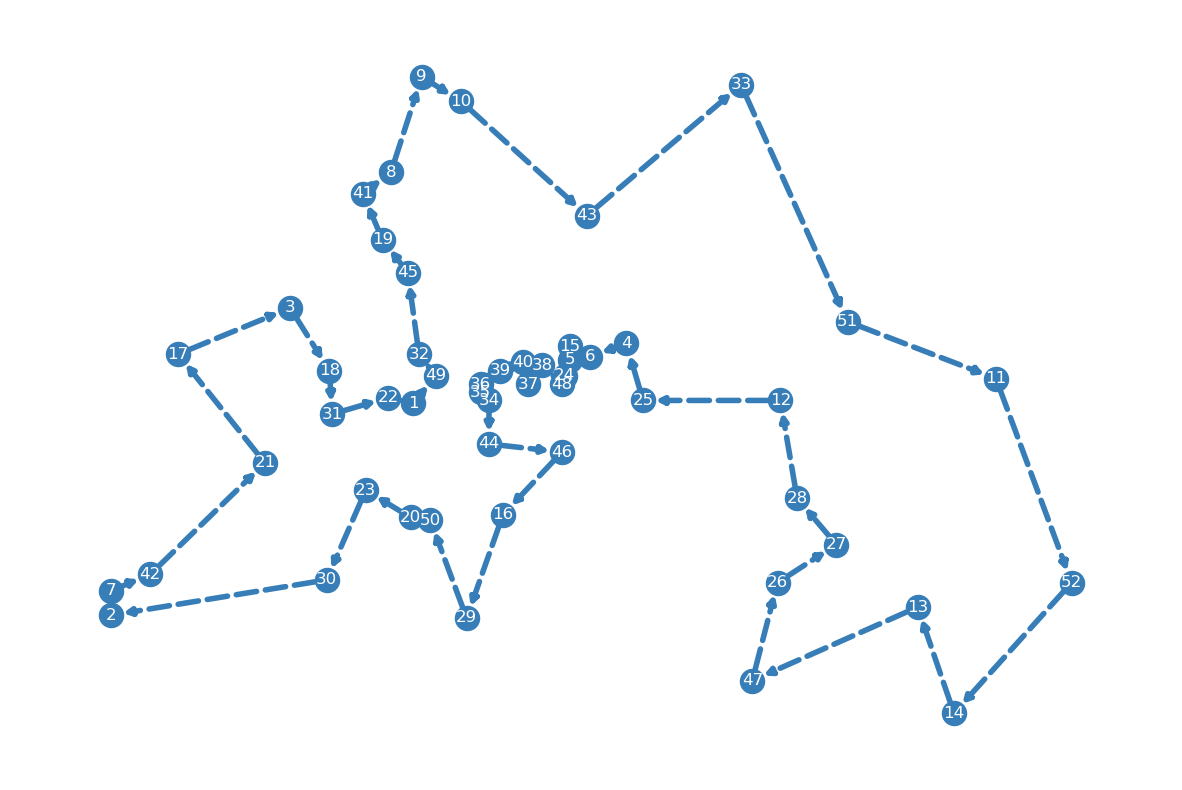

In [78]:
#| label: fig-tsp-berlin52-sol
#| fig-cap: Optimal tour of the *berlin52* instance
visualize_tsp('berlin52')

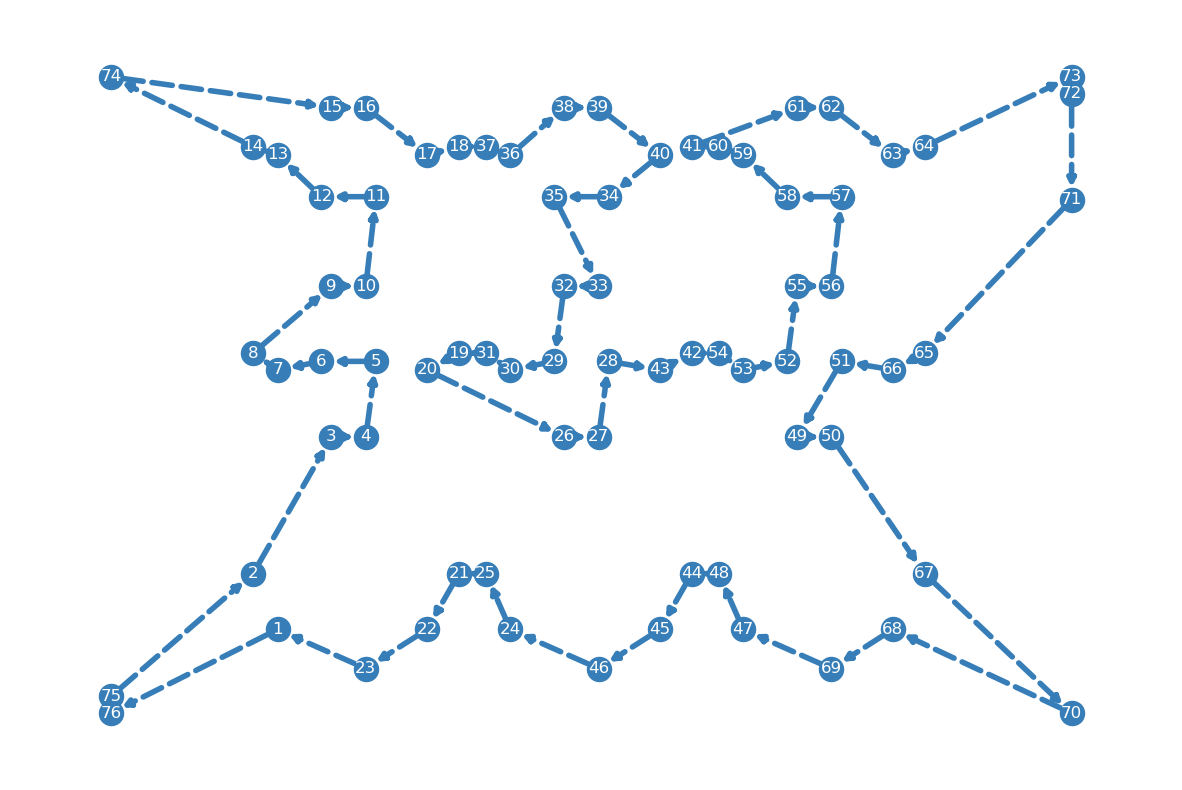

In [79]:
#| label: fig-tsp-pr76-sol
#| fig-cap: Optimal tour of the *pr76* instance
visualize_tsp('pr76')

## Problem Description

Let $\mathcal{G} = (\mathcal{V}, \mathcal{A})$ be an undirected complete graph, where $V = \{1, 2, \cdots, n\}$ represents a set of $n$ cities or vertices, and $\mathcal{A} = \{(i, j)\ |\ i, j \in \mathcal{V}, i \neq j\}$ represents the set of edges connecting these cities. 
The edges in $\mathcal{A}$ have weights or distances associated with them, $c_{ij}$, representing the distances or costs to travel between pairs of cities.

The objective of the TSP is to find the shortest possible closed tour that visits each city in $\mathcal{V}$ exactly once and returns to the starting city, while obeying the following constraints:

- Each city must be visited exactly once: The tour must include all the cities in $\mathcal{V}$, and each city must be visited exactly once during the tour.
- The tour must be closed: The last city visited in the tour must be the same as the starting city, forming a closed loop.

## Model 1 - DFJ

The first formulation was proposed by @dantzig_solution_1954.
It uses the following decision variables:

- $x_{ij}$: a binary variable that equals 1 if arc $(i, j) \in \mathcal{A}$ shows up in the optimal solution, 0 otherwise

We can state the model as follows:

\begin{align}
\text{min.} &\quad \sum_{(i, j) \in \mathcal{A}} c_{ij} x_{ij} \label{tsp1-obj} \\
\text{s.t.} &\quad \sum_{j \in \mathcal{V},\  j \neq i} x_{ij} = 1, \ \forall i \in \mathcal{V} \label{tsp1-cons1} \\
&\quad \sum_{i \in \mathcal{V}, \ i \neq j} x_{ij} = 1, \ \forall j \in \mathcal{V} \label{tsp1-cons2}\\
&\quad 
\begin{split}
    & \sum_{i, j \in S, \ (i, j) \in \mathcal{A}} x_{ij} \leq |S| - 1,\\
    &\qquad \forall S \subset \mathcal{V}, \ 2 \leq |S| \leq n - 2 
\end{split}
\label{tsp1-cons3}  \\
&\quad x_{ij} \in \{0, 1\}, \ \forall (i, j) \in \mathcal{A}
\end{align}

In this formulation, the objective \eqref{tsp1-obj} aims to minimize the total distance of the optimal tour.
Constraints \eqref{tsp1-cons1} and \eqref{tsp1-cons2} make sure that each node is entered and left once and only once, and they are also called *degree constraints*.
Constraints \eqref{tsp1-cons3} are the so-called *subtour elimination constraints*.

@fig-subtour1 and @fig-subtour2 show two subtours with 2 and 3 nodes, respectively.
Note that the number of arcs (edges) in a subtour equals to the number of nodes.
Therefore, 

```{mermaid}
%%| label: fig-subtour1
%%| fig-cap: Subtour with 2 nodes

flowchart LR
    A((1)) --> B((2))
    B --> A
```

```{mermaid}
%%| label: fig-subtour2
%%| fig-cap: Subtour with 3 nodes
flowchart LR
    A((1)) --> B((2))
    B --> C((3))
    C --> A
```

## Model 2 - MTZ

## Model 3 - Single Commodity Flow


## Model 4 - Two Commodity Flow

## Model 5 - Multi-Commodity Flow